# **Tackle Imbalanced Data Challenge**

In this lab, you will identify the imbalanced data problems in four binary classification scenarios, all with skewed class distributions:


| Task Name     | Class Ratio (Negative vs. Positive)  |
| ------------- |:-------------:|
| _Credit Card Fraud Detection_      | ~1000 : 1      |
| _Predicting Customer Churn_ | ~5 : 1      |
| _Tumor Type Estimation_ | ~2 : 1     |
| _Predicting Job Change_ | ~10 : 1      |


In [190]:
import pandas as pd
import numpy as np
import imblearn
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_recall_fscore_support,
    confusion_matrix, precision_score, recall_score, roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.inspection import permutation_importance
from collections import Counter


In [191]:
rs = 123
# Grid search hyperparameters for a logistic regression model
def grid_search_lr(X_train, y_train):
    params_grid = {
    'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}]
    }
    lr_model = LogisticRegression(random_state=rs, max_iter=1000)
    grid_search = GridSearchCV(estimator = lr_model,
                           param_grid = params_grid,
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Grid search hyperparameters for a random forest model
def grid_search_rf(X_train, y_train):
    params_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [25, 50, 100],
    'min_samples_split': [2, 5],
    'class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}]
    }
    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model,
                           param_grid = params_grid,
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

## Scenario: Credit Card Fraud Detection


In [192]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_credit.csv", index_col=False)
df.head()

,V14,V17,V4,V10,V28,Class
0,0.423619,-0.210863,0.933459,0.027866,0.019308,0
1,0.986727,0.174009,-2.019905,-1.620065,-0.307753,0
2,-0.023094,-0.541985,-0.902618,-0.192212,-0.048965,0
3,-0.152111,-0.615094,1.276126,-0.026822,0.044480,0
4,-0.535807,-0.248563,4.517539,1.871441,0.120955,0


Due to confidentiality issues,the original features and other background information about each transaction is hidden

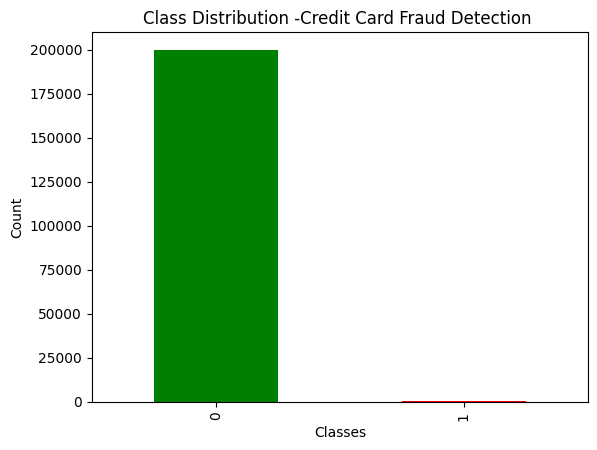

In [193]:
df['Class'].value_counts().plot.bar(color=['green', 'red'])
plt.title("Class Distribution -Credit Card Fraud Detection ")  # Replace with dataset name
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

In [194]:
X = df.loc[ : , df.columns != 'Class']
y = df['Class'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 123)

In [195]:
model = LogisticRegression(random_state=123,
                              max_iter = 1000)

# Train the model
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [196]:
accuracy_score(y_test, preds)

0.9992757242757243

In [197]:
accuracy = accuracy_score(y_test, preds)
precision, recall, fbeta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
auc = roc_auc_score(y_test, preds)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {fbeta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 1.00
Precision is: 0.72
Recall is: 0.45
Fscore is: 0.46
AUC is: 0.72


recall is very low


### Synthetic Minority Oversampling Technique (SMOTE)


In [198]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

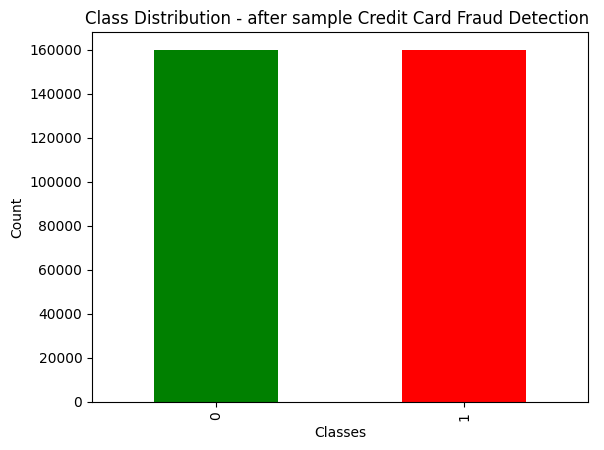

In [199]:
smote_sampler = SMOTE(random_state = 123)
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
y_smo.value_counts().plot.bar(color=['green', 'red'])
plt.title("Class Distribution - after sample Credit Card Fraud Detection ")  # Replace with dataset name
plt.xlabel("Classes")
plt.ylabel("Count")

plt.show()

In [200]:
model.fit(X_smo, y_smo)
preds = model.predict(X_test)

In [201]:
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
auc = roc_auc_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 0.97
Precision is: 0.03
Recall is: 0.88
Fscore is: 0.42
AUC is: 0.92


### Class reweighting


In [202]:
class_weight = {}
class_weight[0] = 0.1
class_weight[1] = 0.9

In [203]:
model = LogisticRegression(random_state=123,
                              max_iter = 1000,
                              class_weight=class_weight)
# Train the model
model.fit(X_train, y_train)
# Make predictions on the test dataset
preds = model.predict(X_test)

In [204]:
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
auc = roc_auc_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 1.00
Precision is: 0.65
Recall is: 0.82
Fscore is: 0.82
AUC is: 0.91


As you can see, we have much balanced `Precision` and `Recall` values. It indicates that, for an extremely imbalanced dataset like credit card fraud detection, often class reweighting is a better strategy than oversampling. Since undersampling will significantly shrink the training dataset, we normally do not use undersampling for an extremely imbalanced dataset.


## Scenario: Predicting Customer Churn


In [205]:
churn_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_churn.csv", index_col=False)
churn_df.head()

,tenure,MonthlyCharges,TotalCharges,Partner_0,Partner_1,Dependents_0,Dependents_1,PhoneService_0,PhoneService_1,MultipleLines_0,...,Contract_0,Contract_1,Contract_2,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,Class
0,27,70.55,1943.90,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
1,69,93.30,6398.05,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,55,59.20,3175.85,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
3,49,59.60,2970.30,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,72,109.55,7887.25,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0


In [206]:
def split_data(df):
    X = df.loc[ : , df.columns != 'Class']
    y = df['Class'].astype('int')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state = 123)

In [207]:
X_train, X_test, y_train, y_test = split_data(churn_df)

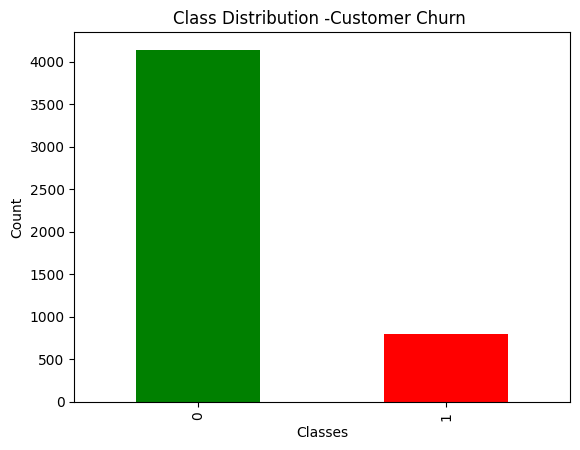

In [209]:
y_train.value_counts().plot.bar(color=['green', 'red'])
plt.title("Class Distribution -Customer Churn ")  # Replace with dataset name
plt.xlabel("Classes")
plt.ylabel("Count")

plt.show()

As we can see from the bar chart above, the non-churn customers are almost 4 times more than the churn customers, which makes it an imbalanced dataset as well. Since this dataset has 42 features, it would be better to use a more complex classification model and we choose to use `RandomForestClassifier` from `sklearn` package.


In [210]:
rs = 123
# Build a logistic regression model
def build_lr(X_train, y_train, X_test, threshold=0.5, best_params=None):

    model = LogisticRegression(random_state=rs,
                              max_iter = 1000)
    # If best parameters are provided
    if best_params:
        model = LogisticRegression(penalty = 'l2',
                              random_state=rs,
                              max_iter = 1000,
                              class_weight=best_params['class_weight'])
    # Train the model
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

In [211]:
def build_rf(X_train, y_train, X_test, threshold=0.5, best_params=None):

    model = RandomForestClassifier(random_state = 123)
    # If best parameters are provided
    if best_params:
        model = RandomForestClassifier(random_state = 123,
                                   # If bootstrap sampling is used
                                   bootstrap = best_params['bootstrap'],
                                   # Max depth of each tree
                                   max_depth = best_params['max_depth'],
                                   # Class weight parameters
                                   class_weight=best_params['class_weight'],
                                   # Number of trees
                                   n_estimators=best_params['n_estimators'],
                                   # Minimal samples to split
                                   min_samples_split=best_params['min_samples_split'])
    # Train the model
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

In [212]:
rs = 123
def evaluate(yt, yp, eval_type="Original"):
    results_pos = {}
    results_pos['type'] = eval_type
    # Accuracy
    results_pos['accuracy'] = accuracy_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, beta=5, pos_label=1, average='binary')
    results_pos['recall'] = recall
    # AUC
    results_pos['auc'] = roc_auc_score(yt, yp)
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta
    return results_pos

In [213]:
def resample(X_train, y_train):
    # SMOTE sampler (Oversampling)
    smote_sampler = SMOTE(random_state = 123)
    # Undersampling
    under_sampler = RandomUnderSampler(random_state=123)
    # Resampled datasets
    X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train)
    return X_smo, y_smo, X_under, y_under

In [214]:
def visualize_eval_metrics(results):
    df = pd.DataFrame(data=results)
    #table = pd.pivot_table(df, values='type', index=['accuracy', 'precision', 'recall', 'f1', 'auc'],
    #                columns=['type'])
    #df = df.set_index('type').transpose()
    print(df)
    x = np.arange(5)
    original = df.iloc[0, 1:].values
    class_weight = df.iloc[1, 1:].values
    smote = df.iloc[2, 1:].values
    under = df.iloc[3, 1:].values
    width = 0.2
    figure(figsize=(12, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])

    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(["Original", "Class Weight", "SMOTE", "Undersampling"])
    plt.show()

In [215]:
best_params_no_weight = {'bootstrap': True,
                         'class_weight': None,
                         'max_depth': 10,
                         'min_samples_split': 5,
                         'n_estimators': 50}

In [216]:
results = []

In [217]:
preds, model = build_rf(X_train, y_train, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds, "Original")
print(result)
results.append(result)

{'type': 'Original', 'accuracy': 0.8623481781376519, 'recall': 0.28, 'auc': np.float64(0.6274396135265701), 'precision': 0.6829268292682927, 'fscore': 0.2865013774104683}


### Add class re-weighting


In [218]:
class_weight = {}
# 0.2 to Non-churn class
class_weight[0] = 0.2
# 0.8 to Churn class
class_weight[1] = 0.8


In [219]:
# Pre-tuned hyper parameters
best_params_weight = {'bootstrap': True,
                         'class_weight': class_weight,
                         'max_depth': 10,
                         'min_samples_split': 5,
                         'n_estimators': 50}

In [220]:
preds_cw, weight_model = build_rf(X_train, y_train, X_test, best_params=best_params_weight)
result = evaluate(y_test, preds_cw, "Class Weight")
print(result)
results.append(result)

{'type': 'Class Weight', 'accuracy': 0.8137651821862348, 'recall': 0.62, 'auc': np.float64(0.7356038647342995), 'precision': 0.4460431654676259, 'fscore': 0.6108374384236454}


### Resampling: SMOTE and Undersampling


In [221]:
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)
preds_smo, smo_model = build_rf(X_smo, y_smo, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds_smo, "SMOTE")
print(result)
results.append(result)

{'type': 'SMOTE', 'accuracy': 0.8340080971659919, 'recall': 0.505, 'auc': np.float64(0.7012922705314009), 'precision': 0.48792270531400966, 'fscore': 0.504321106203188}


In [222]:
preds_under, under_model = build_rf(X_under, y_under, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds_under, "Undersampling")
print(result)
results.append(result)

{'type': 'Undersampling', 'accuracy': 0.7336032388663968, 'recall': 0.79, 'auc': np.float64(0.7563526570048309), 'precision': 0.3550561797752809, 'fscore': 0.7544536271808999}


            type  accuracy  recall       auc  precision    fscore
0       Original  0.862348   0.280  0.627440   0.682927  0.286501
1   Class Weight  0.813765   0.620  0.735604   0.446043  0.610837
2          SMOTE  0.834008   0.505  0.701292   0.487923  0.504321
3  Undersampling  0.733603   0.790  0.756353   0.355056  0.754454


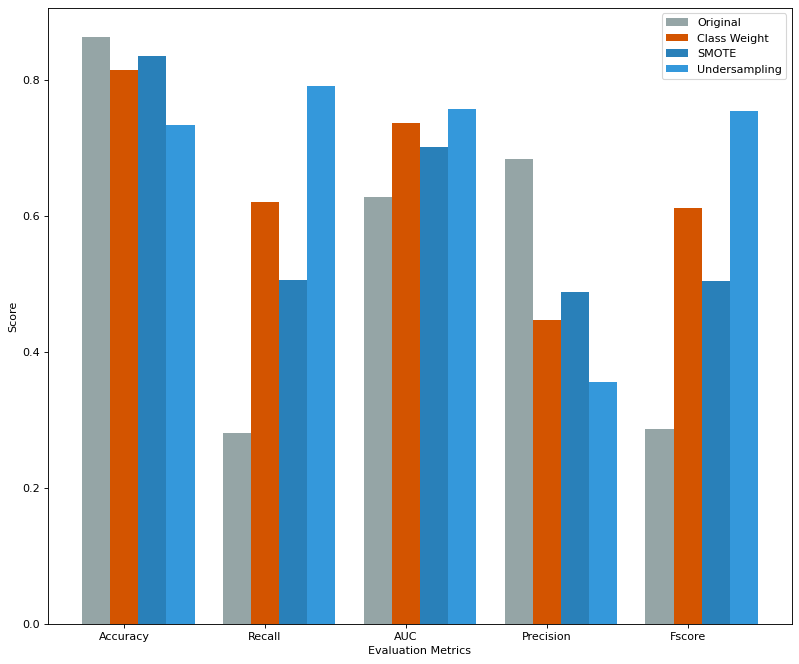

In [223]:
visualize_eval_metrics(results)

- All models have high accuracy
- Recall is improved with class weights and resampling methods, and undersampling produces the highest recall
- AUC is also improved with class weights and resampling methods, and undersampling produces the highest AUC again
- Precisions are decreased with class weights and resampling methods as they all introduced many false positives (which are expected as we are trying to increase the impact of the positive class)
- Fscore is improved with class weights and resampling method, and undersampling has the highest Fscore


## Scenario: Tumor Type Estimation


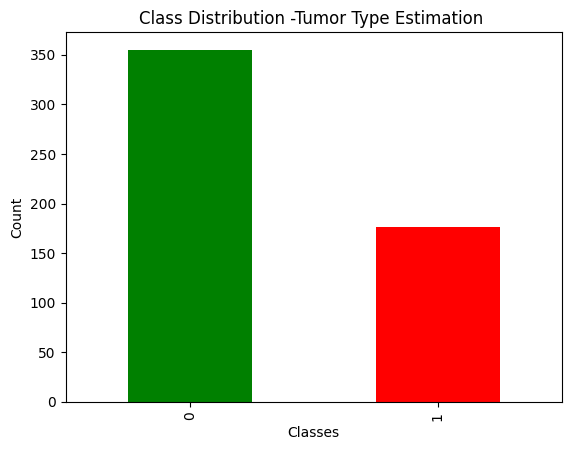

In [224]:
tumor_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_cancer.csv", index_col=False)
X_train, X_test, y_train, y_test = split_data(tumor_df)
y_train.value_counts().plot.bar(color=['green', 'red'])
plt.title("Class Distribution -Tumor Type Estimation ")  # Replace with dataset name
plt.xlabel("Classes")
plt.ylabel("Count")

plt.show()

In [225]:
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

In [226]:
best_params_weight = {'bootstrap': True,
                         'class_weight': {0: 0.2, 1: 0.8},
                         'max_depth': 10,
                         'min_samples_split': 5,
                         'n_estimators': 50}

In [227]:
# no class-weights
results=[]
preds, model = build_rf(X_train, y_train, X_test)
results.append(evaluate(y_test, preds))
# class weight
preds, model = build_rf(X_train, y_train, X_test, best_params=best_params_weight)
results.append(evaluate(y_test, preds))
# Resampling
preds, model = build_rf(X_smo, y_smo, X_test)
results.append(evaluate(y_test, preds))
preds, model = build_rf(X_under, y_under, X_test)
results.append(evaluate(y_test, preds))

       type  accuracy  recall       auc  precision    fscore
0  Original  0.984962     1.0  0.988764   0.956522  0.998255
1  Original  0.992481     1.0  0.994382   0.977778  0.999127
2  Original  0.992481     1.0  0.994382   0.977778  0.999127
3  Original  0.984962     1.0  0.988764   0.956522  0.998255


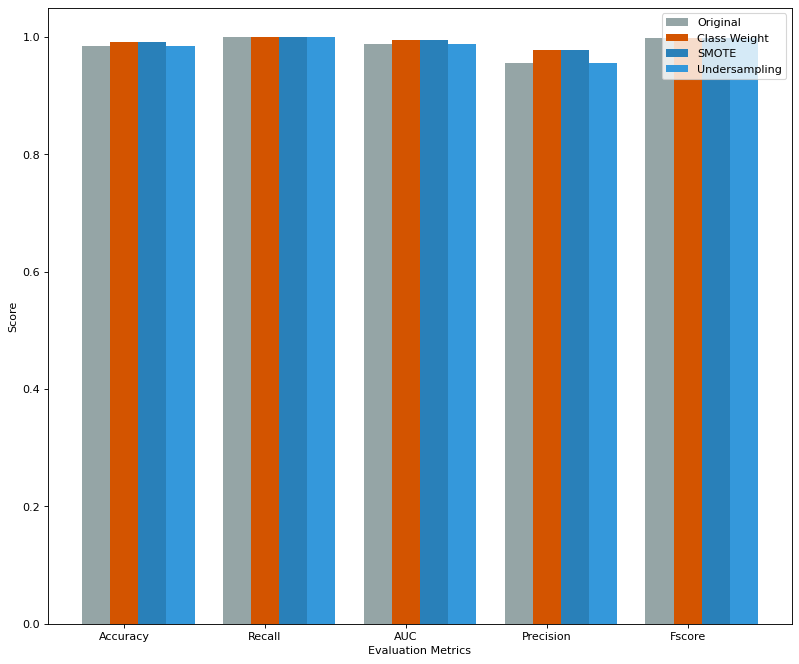

In [228]:
visualize_eval_metrics(results)

As we can see, all grey bars (the original model) for Accuracy, Recall, AUC, Precision, and F-score have very high values and adding class reweighting and resampling does not help improve performance that much. This is possible that the tumor patterns in this dataset are obvious and can be easily picked up by the standard random forest model or the dataset is not very imbalanced and can be considered as an ordinary binary classification task.


## Exercise: Predicting Job Change


In [229]:
hr_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_hr.csv", index_col=False)

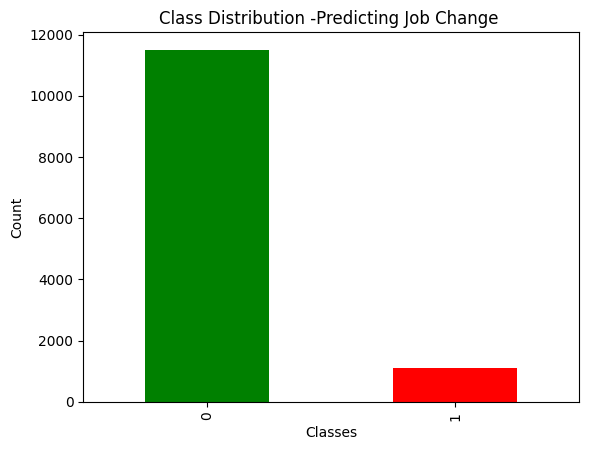

In [230]:
X_train, X_test, y_train, y_test = split_data(hr_df)
y_train.value_counts().plot.bar(color=['green', 'red'])
plt.title("Class Distribution -Predicting Job Change ")  # Replace with dataset name
plt.xlabel("Classes")
plt.ylabel("Count")

plt.show()

try it userful dude-------